# Distributed cross-validation when training a classifier

This notebook shows how to train a classifier on a set of digits (the MNIST dataset), using a random forest classifier as the base method.
There are a number of parameters to adjust, which we are going to tune automatically by doing a grid search: we are going to run the same classifier multiple times using different parameters, and report the best ones.

The scikit-learn package already provides a method to tune a classifier using cross-validation, but this implementation is not distributed. We are going to compare it against a distributed implementation built on top of Spark.

In order to run this code, you need to have the [spark-sklearn](https://pypi.python.org/pypi/spark-sklearn) library installed, which you can get from pypi.

To use spark-scikit gridsearch simply replace

```
from sklearn.model_selection import GridSearchCV
...
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)```

with

```
from spark_sklearn import GridSearchCV
...
grid = GridSearchCV(sc, pipe, cv=3, n_jobs=1, param_grid=param_grid)```

In [3]:
from sklearn import svm, grid_search, datasets
from sklearn.model_selection import GridSearch
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=parameters)
clf.fit(iris.data, iris.target)

In [4]:
from sklearn import svm, grid_search, datasets
from spark_sklearn import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = GridSearchCV(sc, svr, parameters)
clf.fit(iris.data, iris.target)

Let us run the cross-validation classifier that trains on each of the configuration, using only the driver. This is going to take about 40 seconds. This classifier does not make use of the cluster.

[source](http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html#sphx-glr-auto-examples-plot-compare-reduction-py)

In [6]:
# Authors: Robert McGibbon, Joel Nothman, Guillaume Lemaitre

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

print(__doc__)

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.
 Out[ 17 ]: <matplotlib.legend.Legend at 0x7f746d7288d0>

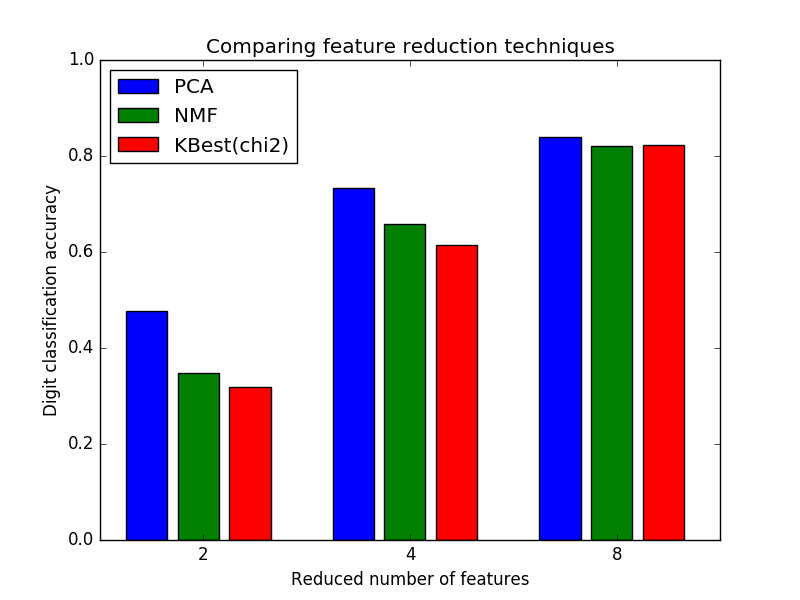

In [7]:
display()

Now, we run the same code, using the distribute classifier. It is a drop-in replacement; all the code around is unchanged.

It takes about 8 seconds on my cluster of 2 machines.

In [9]:
# Authors: Robert McGibbon, Joel Nothman, Guillaume Lemaitre

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from spark_sklearn import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

print(__doc__)

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(sc, pipe, cv=3, n_jobs=1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.
 Out[ 19 ]: <matplotlib.legend.Legend at 0x7f74644287d0>

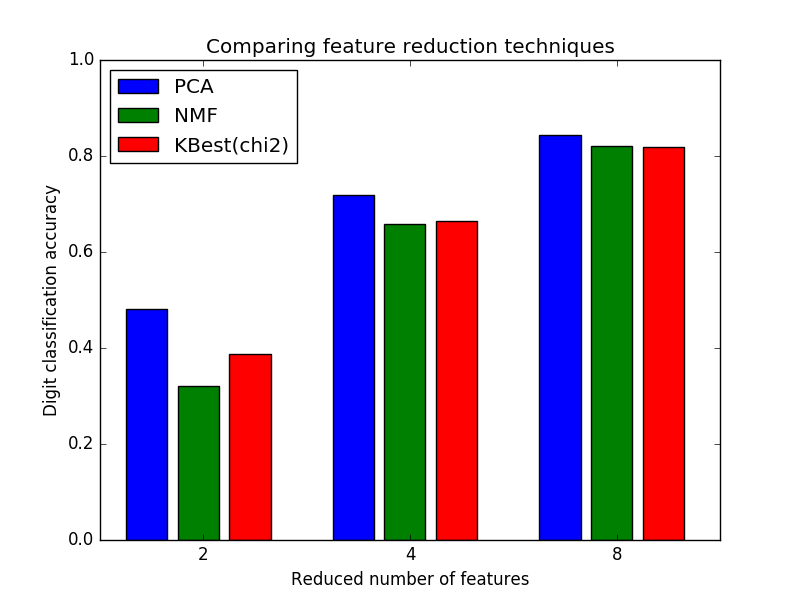

In [10]:
display()

In the below benchmark, we are able to use grid search to cross validate multiple models against each other and choose the best model.

We go from an 11 minute run to a 2 minute run. Over 5x faster!

We could potentially achieve even better results by distributing over more cores.

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Load and split the data
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
			('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()),
			('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
			('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', svm.SVC(random_state=42))])
			
# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10) 
			
gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10)
			
gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
		2: 'Random Forest', 3: 'Random Forest w/PCA', 
		4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print('\nEstimator: %s' % grid_dict[idx])	
	# Fit grid search	
	gs.fit(X_train, y_train)
	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training data accuracy
	print('Best training accuracy: %.3f' % gs.best_score_)
	# Predict on test data with best params
	y_pred = gs.predict(X_test)
	# Test data accuracy of model with best params
	print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
	# Track best (highest test accuracy) model
	if accuracy_score(y_test, y_pred) > best_acc:
		best_acc = accuracy_score(y_test, y_pred)
		best_gs = gs
		best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# # Save best grid search pipeline to file
# dump_file = 'best_gs_pipeline.pkl'
# joblib.dump(best_gs, dump_file, compress=1)
# print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__penalty': 'l1', 'clf__C': 1.0, 'clf__solver': 'liblinear'}
Best training accuracy: 0.917
Test set accuracy score for best params: 0.967 

Estimator: Logistic Regression w/PCA
Best params: {'clf__penalty': 'l1', 'clf__C': 0.5, 'clf__solver': 'liblinear'}
Best training accuracy: 0.858
Test set accuracy score for best params: 0.933 

Estimator: Random Forest
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Best training accuracy: 0.942
Test set accuracy score for best params: 1.000 

Estimator: Random Forest w/PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}
Best training accuracy: 0.917
Test set accuracy score for best params: 0.900 

Estimator: Support Vector Machine
Best params: {'clf__C': 3, 'clf__kernel': 'linear'}
Best training accuracy: 0.967
Test set accuracy score for best params: 0.967 

Estimator: Support Vector Machine w/PCA
Best params: {'clf__C': 4, 'clf__kernel': 'rbf'}
Best training accuracy: 0.925
Test set accuracy score for best params: 0.900 

Classifier with best test set accuracy: Random Forest

# Use spark-sklearn

In [14]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from spark_sklearn import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Load and split the data
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
			('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()),
			('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
			('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', svm.SVC(random_state=42))])
			
# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(sc, estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10) 
			
gs_lr_pca = GridSearchCV(sc, estimator=pipe_lr_pca,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10)
			
gs_rf = GridSearchCV(sc, estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_rf_pca = GridSearchCV(sc, estimator=pipe_rf_pca,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_svm = GridSearchCV(sc, estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

gs_svm_pca = GridSearchCV(sc, estimator=pipe_svm_pca,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
		2: 'Random Forest', 3: 'Random Forest w/PCA', 
		4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print('\nEstimator: %s' % grid_dict[idx])	
	# Fit grid search	
	gs.fit(X_train, y_train)
	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training data accuracy
	print('Best training accuracy: %.3f' % gs.best_score_)
	# Predict on test data with best params
	y_pred = gs.predict(X_test)
	# Test data accuracy of model with best params
	print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
	# Track best (highest test accuracy) model
	if accuracy_score(y_test, y_pred) > best_acc:
		best_acc = accuracy_score(y_test, y_pred)
		best_gs = gs
		best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# # Save best grid search pipeline to file
# dump_file = 'best_gs_pipeline.pkl'
# joblib.dump(best_gs, dump_file, compress=1)
# print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__penalty': 'l1', 'clf__C': 1.0, 'clf__solver': 'liblinear'}
Best training accuracy: 0.917
Test set accuracy score for best params: 0.967 

Estimator: Logistic Regression w/PCA
Best params: {'clf__penalty': 'l1', 'clf__C': 0.5, 'clf__solver': 'liblinear'}
Best training accuracy: 0.858
Test set accuracy score for best params: 0.933 

Estimator: Random Forest
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Best training accuracy: 0.942
Test set accuracy score for best params: 1.000 

Estimator: Random Forest w/PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}
Best training accuracy: 0.917
Test set accuracy score for best params: 0.900 

Estimator: Support Vector Machine
Best params: {'clf__C': 3, 'clf__kernel': 'linear'}
Best training accuracy: 0.967
Test set accuracy score for best params: 0.967 

Estimator: Support Vector Machine w/PCA
Best params: {'clf__C': 4, 'clf__kernel': 'rbf'}
Best training accuracy: 0.925
Test set accuracy score for best params: 0.900 

Classifier with best test set accuracy: Random Forest